# Topic Modelling (Part 1): Introduction to text embeddings

Topic modelling is an unsupervised document classification task, in which we assign each document or phrase in a corpus with a label, depending on the abstract properties of each corpus entry. So the difficulty comes from trying to find these properties from the text. 

In regular classification tasks we would have a set of features and an output variable, for text these features could be: number of words in the document, number of times a specific word is mentioned, even the number of positive and negative words if we use a sentiment lexicon. Then we would use some classification model, like logistic regression, and predict how likely is a document to have a certain label. However, in real world scenarios this isn't very useful, it would be a monumental task to do extract the most relevant features from a corpus of thousands of text with thousands of words each. So, what if instead of having to engineer features from the text we let the text be the features; meaning, use the words in the documents to compare them. But we can't input a sequence of characters into a mathematical formula, this is when vector semantics appear. The idea is to represent the meaning of word according to the context it appears in.

[comment]: <> (The easiest way to represent words with numerical vectors is to do one-hot-encoding, this means we extract all the unique words used in the corpus and assign each one a vector of the size of the vocubulary $|V|$, with zeroes in all entries but one. This is a good way to start for most models, but there isn't much information to gain from just one-hot-encoded vectors. )

In this post we will take a look at the simplest methods to represent text as numerical vectors using the 20newsgroups dataset. We will import the dataset from the sklearn package and use string and pandas to do some manipulation. Firstly we choose 4 random categories for simplicity and put the dataset into a dataframe.

In [1]:
import string
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset = 'train', categories=['comp.graphics', 'rec.autos', 
                                                              'sci.space', 'talk.politics.misc'])
categories = [newsgroups["target_names"][i] for i in newsgroups["target"]]
newsgroups_df = pd.DataFrame({"data": newsgroups["data"],
                             "target": newsgroups["target"],
                             "category": categories})

c:\Users\jose_\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We will be using the news categories as documents; therefore, we can use the `groupby` and `join` functions from pandas to join all the documents in one category together.

In [2]:
def join_strings(series):
    return ' '.join(series)
news_by_category = newsgroups_df.groupby("category")['data'].agg(join_strings).reset_index()

## Term-document representations
The simplest approach is to have a term-document matrix, where every column is the name of a document and every row is a term from a vocabulary made out of the whole corpus, and every cell is the number of times that term appears in that document. First step to build a term-document matrix is to separate the documents into individual words, this process is called *tokenization*. Here we convert the whole text to lower case, and we split it by word (it splits every time it detects a space), then we remove the punctuation characters.

In [3]:
def contains_number(s):
    return bool(re.search(r'\d', s))

news_by_category["tokens"] = None
for i, text in enumerate(news_by_category.data):
    tokenized_cat = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)
        if len(token) > 0 and not contains_number(token):
            tokenized_cat.append(token)
    news_by_category["tokens"][i] = tokenized_cat 

Next we want to count the number of words per category.

In [4]:
news_tokenized = news_by_category.drop('data', axis=1). \
    explode('tokens').  \
    groupby(['category', 'tokens']).size(). \
    reset_index(name='count')

news_tokenized.head()

,category,tokens,count
0,comp.graphics,a,2628
1,comp.graphics,a&m,6
2,comp.graphics,a)bort,4
3,comp.graphics,"a,b,c",2
4,comp.graphics,a-b,1


Now we are ready to build the matrix, we will choose a few specific words for visualization purposes.

In [5]:
news_tokenized[news_tokenized.tokens.isin(["computer", "space", "cars", "from", "republican"])]. \
    pivot(index='tokens', columns='category', values='count'). \
    fillna(0).astype(int)

category,comp.graphics,rec.autos,sci.space,talk.politics.misc
tokens,,,,
cars,2,365,2,8
computer,205,68,86,40
from,1177,945,1280,1146
republican,0,0,1,25
space,47,15,1194,19


In the following we have a simple two-dimensional vectror representation of the documents

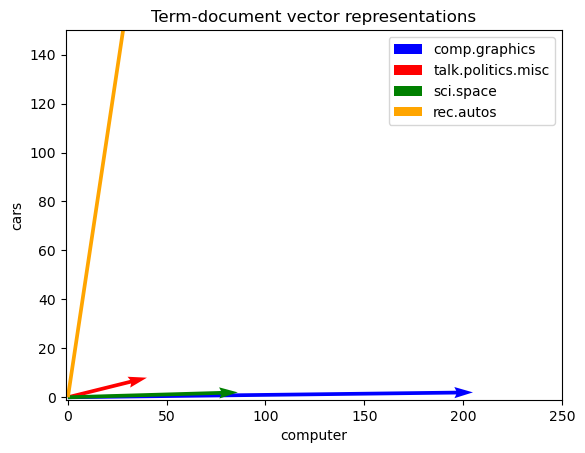

In [6]:
# Create a figure and axis
fig, ax = plt.subplots()

# Create a quiver plot for the vectors
ax.quiver(0, 0, 205, 2, angles='xy', scale_units='xy', scale=1, color='blue', label='comp.graphics')
ax.quiver(0, 0, 40, 8, angles='xy', scale_units='xy', scale=1, color='red', label='talk.politics.misc')
ax.quiver(0, 0, 86, 2, angles='xy', scale_units='xy', scale=1, color='green', label='sci.space')
ax.quiver(0, 0, 68, 365, angles='xy', scale_units='xy', scale=1, color='orange', label='rec.autos')

# Set x and y axis limits
ax.set_xlim(-1, 250)
ax.set_ylim(-1, 150)

# Add labels and legend
ax.set_xlabel('computer')
ax.set_ylabel('cars')
ax.set_title('Term-document vector representations')
ax.legend()

# Show the plot
plt.show()

## Term-term representations
Another way of achieving this is with the term-term co-occurrence matrices, this a matrix of $|V|\times|V|$, where $|V|$ is the vocabulary size, made up of context words in the columns and target words in the rows. Each entry corresponds to the number of times those terms appear together in the document. 

In [7]:
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))
tokens = [word for word in news_by_category.iloc[0,:]['tokens'] if word not in stop_words and not contains_number(word)]
counts = pd.Series(tokens).value_counts()

vocabulary = list(set(tokens))
term_to_index = {term: idx for idx, term in enumerate(vocabulary)}

In [8]:
#window = 2
#co_occurrence_matrix = pd.DataFrame(columns=vocabulary, index=vocabulary).fillna(0)
#
#for i, target in enumerate(tokens):
#    for context in tokens[i-window:i+window+1]:
#        if target == context:
#            co_occurrence_matrix.loc[target, context] = counts[target]
#        else:
#            co_occurrence_matrix.loc[target, context] += 1

In [10]:
window = 2
numpy_matrix = np.zeros((len(vocabulary), len(vocabulary)), dtype=int)
for i in range(len(tokens)):
    for j in range(i-window, i+window+1):
        if 0 <= j < len(tokens):
            if i == j:  
                numpy_matrix[term_to_index[tokens[i]],term_to_index[tokens[j]]] = counts[tokens[i]]
            else:
                numpy_matrix[term_to_index[tokens[i]],term_to_index[tokens[j]]] += 1


In [11]:
co_occurrences = pd.DataFrame(numpy_matrix, columns=vocabulary, index=vocabulary)
co_occurrences.loc[["computer", "lines", "graphics", "spline", "image"], 
                   ["computer", "lines", "graphics", "spline", "image"]]

,computer,lines,graphics,spline,image
computer,205,13,57,0,7
lines,13,640,9,1,3
graphics,57,9,437,0,4
spline,0,1,0,15,0
image,7,3,4,0,514


Next is another simple visualization of the word vectors.

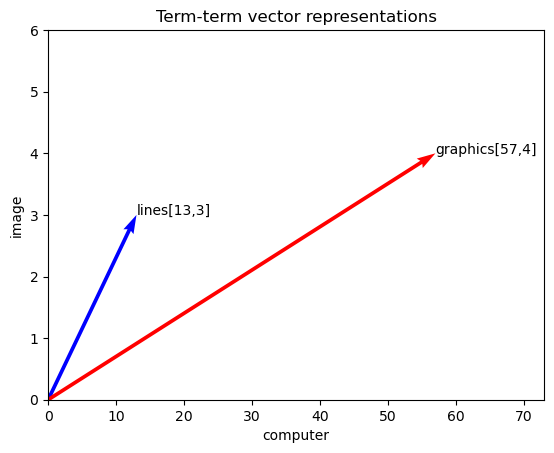

In [47]:
# Define the x and y axis (context words)
x = co_occurrences["computer"]
y = co_occurrences["image"]

# Create a figure and axis
fig, ax = plt.subplots()

# Create a quiver plot for the vectors
ax.quiver([0,0], [0,0], 
          x[["lines", "graphics"]], y[["lines", "graphics"]], 
          angles='xy', scale_units='xy', scale=1, color=['blue','red'])

# Set x and y axis limits
ax.set_xlim(0, 73)
ax.set_ylim(0, 6)

# Add labels and legend
ax.set_xlabel('computer')
ax.set_ylabel('image')
ax.set_title('Term-term vector representations')

ax.annotate("lines[{},{}]".format(x.lines, y.lines),(x["lines"],y["lines"]))
ax.annotate("graphics[{},{}]".format(x.graphics, y.graphics),(x["graphics"],y["graphics"]))
# Show the plot
plt.show()

## TF-IDF
Both methods that we've explored so far used raw frequencies to represent words, in practice these aren't very useful because the most frequent words will always be *the*, *for*, *a*, etc. So what we want to extract are those words that appear very often in a specific document but not too often in all documents. The **tf-idf** weighting, where **tf** stands for *term frequency* and **idf** for *inverse document frequency*,  attempts to do just that. As the name suggest **tf** is just the number of times a word *t* appears in document *d*, while **idf** is the inverse proportion of documents that contain word *t*, both functions are often squash by a base 10 logarithm. 
$$
\begin{aligned}
\mathrm{tf}_{t,d} &= \log_{10}(\mathrm{count}(t,d)+1) \\
\mathrm{idf}_t &= \log_{10}\left(\frac{N}{\mathrm{df}_t}\right)
\end{aligned}
$$
Where $N$ is the number of documents in the corpus and $\text{df}_t$ is the number of documents containing term $t$, we add one to the argument of the logarithm in case we have a count of zero. Then the **tf-idf** weights $w_{t,d}$ is the product of the two:
$$
w_{t,d} = \mathrm{tf}_{t,d} \times \mathrm{idf}_t
$$
Since we already counted the tokens per category when we built the term-document matrix, we will compute the inverse document frequency.

In [12]:
tokens_idf = news_tokenized.groupby('tokens').size().reset_index(name='idf')
tokens_idf["idf"] = np.log10(4/tokens_idf['idf'])

For the next step we will merge this dataframe with the previous one and multiply the log of the counts and the idf.

In [13]:
news_tfidf = news_tokenized.merge(tokens_idf, how='left', on='tokens')
news_tfidf["tf-idf"] = np.log10(news_tfidf['count']+1)*news_tfidf['idf']
news_tfidf.head()

,category,tokens,count,idf,tf-idf
0,comp.graphics,a,2628,0.00000,0.000000
1,comp.graphics,a&m,6,0.30103,0.254400
2,comp.graphics,a)bort,4,0.60206,0.420822
3,comp.graphics,"a,b,c",2,0.60206,0.287256
4,comp.graphics,a-b,1,0.60206,0.181238


Next we just have to pivot wider.

In [14]:
news_tfidf[news_tfidf['tokens'].isin(["computer", "cars", "from", "republican", "spline", "ferrari"])]. \
    pivot(index='tokens', columns='category', values='tf-idf').fillna(0)

category,comp.graphics,rec.autos,sci.space,talk.politics.misc
tokens,,,,
cars,0.000000,0.0000,0.000000,0.000000
computer,0.000000,0.0000,0.000000,0.000000
ferrari,0.000000,0.5088,0.000000,0.000000
from,0.000000,0.0000,0.000000,0.000000
republican,0.000000,0.0000,0.090619,0.425949
spline,0.724952,0.0000,0.000000,0.000000


As we can see many of the words have values of zero, this is because they appear in every category so the tf-idf function is flagging them as "not significant". In the next dataframe we are retrieving the 3 words with the highest tf-idf per category.

In [15]:
news_tfidf.groupby('category', group_keys=False).apply(lambda group: group.nlargest(3, 'tf-idf'))

,category,tokens,count,idf,tf-idf
8395,comp.graphics,polygon,111,0.60206,1.233752
11232,comp.graphics,tiff,98,0.60206,1.201492
11887,comp.graphics,vga,81,0.60206,1.152231
16968,rec.autos,honda,71,0.60206,1.118226
13245,rec.autos,automotive,70,0.60206,1.114569
22423,rec.autos,toyota,68,0.60206,1.107097
31089,sci.space,lunar,224,0.60206,1.416155
35630,sci.space,spacecraft,160,0.60206,1.328642
32640,sci.space,orbital,97,0.60206,1.198838
49463,talk.politics.misc,stephanopoulos,348,0.60206,1.530933


This is an example of a class-based tf-idf, which is very useful when doing something like topic modelling, since we want to know what are the keywords for each of our predicted topics. We will cover how to use text embeddings for topic modelling in later posts.